In [1]:
import sys
sys.path.append("../code/")
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error
from model import PhasedSNForecastModel
out_steps = 3

<h1 align="center"> SN Forecast </h1>

## Why?

<h3 align="center">Because Exploding Stars sounds cool.</h3> 

![](img/exploding.gif)

## How?

![](img/bob.jpg)


## Data Used

![image.png](img/tns.png)
![](img/alerce_lc.png)


### Features used 

- Delta time ($diff(mjd)$)
- Magnitude ($magap$)
- Magnitude Error ($sigmagap$)

## Data Preparation

Before preparing the data, it is splitted in train (531 Objects), validation (133 Objects) and test (166 Objects).

1. For each light curve we filter by the filter id (fid = 1).
2. Then each filter lightcurve is sliced
   - We start with $t_1, \dots, t_{10}$ for the model warmup and $t_{11}, \dots, t_{21}$ for forecast.
   - Then the window is grown to $t_1, \dots, t_{11}$ and the forecast is moved by one epoch $t_{12}, \dots, t_{22}$.
   - This is repeated until the window is the size of the lightcurve for that filter.

![](img/data_preparation.png)


After the data preparation the data looks like this:

![](img/prepared_data.png)

Then it is normalized to [0,1].

## Model

Following the TF2 tutorial (https://www.tensorflow.org/tutorials/structured_data/time_series#advanced_autoregressive_model), is an autoregresive model.

1. We get the relative time from the first detection using an time accumulator, then the data and the time is passed trough the network.
1. Uses a PhasedLSTM as a first Layer (thanks to CDonoso for the code) to tackle the irregular sampling from the astronomical data.
3. Then a Dense to get more features.
4. And finally an output layer with just [dt, mag, err].

![](img/sn_rnn_model.png)

The model is trained doing prediction from $t+1$ to $t+3$, to get $t+1$ we just use the historical data (warmup) then the new value is reintroduced to the model to get $t+2$ and so on, this makes the model an autoregresive model similar to an $AR(1)$ process but non-linear (i've read some describe it as a $\text{Non-linear} \ AR(1)$).


## Results for now

In [15]:
#Helper functions
def normalize(data, min_val = None, max_val = None):
    masked_data = np.ma.masked_where(data < 0, data)
    min_val = np.tile([0,0,0], (len(data),1)) if min_val is None else min_val
    max_val = np.tile([15, 23, 1],(len(data),1)) if max_val is None else max_val
    
    for i in range(masked_data.shape[1]):
        masked_data.data[:,i,:] = (masked_data.data[:,i,:] - min_val)/(max_val-min_val)
    
    return_data = masked_data.data
    return_data[masked_data.mask] = -1
    return return_data, min_val, max_val
    
def denormalize(data, min_val, max_val):
    masked_data = np.ma.masked_where(data < 0, data)
    
    for i in range(masked_data.shape[1]):
        masked_data.data[:,i,:] = (masked_data.data[:,i,:] * (max_val-min_val))  +  min_val
    
    return_data = masked_data.data
    return_data[masked_data.mask] = -1
    return return_data

In [18]:
#Loading data
data = np.load("../data/padded_x_train.npy")
len_data = data.shape[1]
X_train, y_train = data[:,:-out_steps,:],  data[:,-out_steps:,:]
X_train, data_min_val, data_max_val = normalize(X_train)
y_train, _, _ = normalize(y_train,min_val=data_min_val, max_val=data_max_val)

data_test = np.load("../data/padded_x_test.npy")[:,:,:]
# data_test, data_test_min_val, data_test_max_val = normalize(data_test)
X_test, y_test = data_test[:,:-out_steps,:], data_test[:,-out_steps:, :]
X_test, data_test_min_val, data_test_max_val = normalize(X_test)
y_test, _, _ = normalize(y_test,min_val=data_test_min_val, max_val=data_test_max_val)

In [19]:
#Loading and preparing model
from model import PhasedSNForecastModel
model = PhasedSNForecastModel(units=64, out_steps=out_steps,features = 3, dropout=0.0)
model.compile(optimizer="rmsprop", loss="mse")
_ = model.fit(X_train[:2], y_train[:2])

1/1 [==============================] - 0s 859us/step - loss: 0.3062


In [20]:
model.load_weights("../data/sn_model_small.h5")

In [22]:
#Doing inference on Train data
y_hat_train = model.predict(X_train)
#Denormalizing train
dX_train = denormalize(X_train, data_min_val,data_max_val)
dy_hat_train = denormalize(y_hat_train, data_min_val,data_max_val)
dy_train = denormalize(y_train, data_min_val,data_max_val)

# Doing inference on Test data
y_hat = model.predict(X_test)
# Denormalizing results
dX_test = denormalize(X_test, data_test_min_val,data_test_max_val)
dy_hat = denormalize(y_hat,data_test_min_val,data_test_max_val)
dy_test = denormalize(y_test,data_test_min_val,data_test_max_val)

In [23]:
# Plotting results
features = ["Time", "Mag", "Error"]

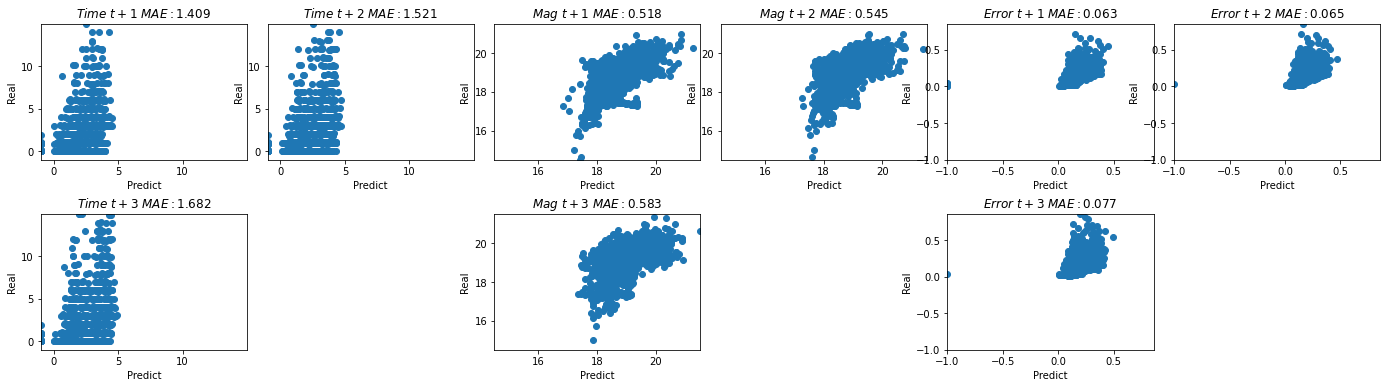

In [39]:
all_rows = np.ceil(out_steps/2).astype(int)
all_columns = len(features)*2
fig2 = plt.figure(figsize=(all_columns*4, all_rows*3))
grid = plt.GridSpec(all_rows, all_columns , wspace=0.1, hspace=0.4)
for i, title in enumerate(features):    
    for t in range(out_steps):
        column = 2*i + (t%2)
        row = t // 2
        
        ax = plt.subplot(grid[row,column])
        mae = mean_absolute_error(dy_test[:,t,i], dy_hat[:,t,i])
        ax.set_title(f"${title} \ t+{t+1} \ MAE:{mae:.3f}$")
        ax.scatter(dy_hat[:,t,i].flatten(),dy_test[:,t,i].flatten())
        ax.set(xlim=(
                np.min([dy_hat[:,:,i].min(), dy_test[:,:,i].min()]), 
                np.max([dy_hat[:,:,i].max(), dy_test[:,:,i].max()])
                ), 
               ylim=(
                np.min([dy_hat[:,:,i].min(), dy_test[:,:,i].min()]), 
                np.max([dy_hat[:,:,i].max(), dy_test[:,:,i].max()])
                ))
        ax.set_xlabel("Predict")
        ax.set_ylabel("Real")
plt.show()

The dispersion plots showns that the model has less problems doing forecast on time than in magnitude and error, but when whe see the MAE values it showns that in time there is a two week difference and in magnitude is only 0.5 mags.

In [25]:
maes_test = {}
for i, title in enumerate(features):
    maes_test[title] = []
    for t in range(out_steps):
        maes_test[title].append(mean_absolute_error(y_test[:,t,i], y_hat[:,t,i]))

In [26]:
maes_train = {}
for i, title in enumerate(features):
    maes_train[title] = []
    for t in range(out_steps):
        maes_train[title].append(mean_absolute_error(y_train[:,t,i], y_hat_train[:,t,i]))

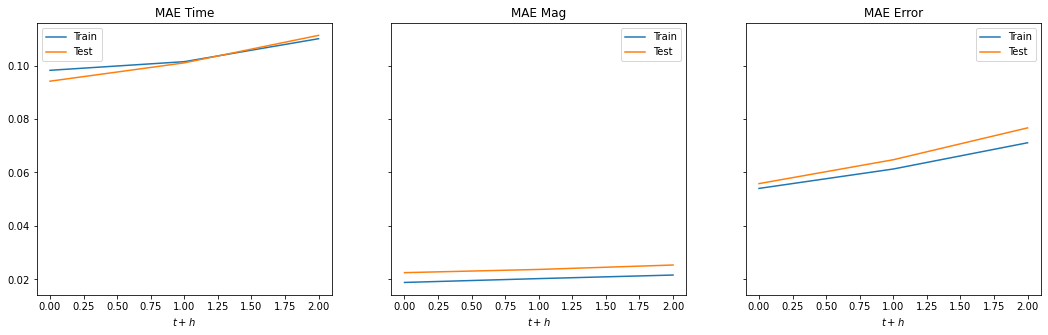

In [27]:
fig,axes = plt.subplots(1,len(features), figsize=(6*len(features),5),sharey=True) 
for i, title in enumerate(features):
    axes[i].plot(maes_train[title], label="Train")
    axes[i].plot(maes_test[title], label="Test")

    axes[i].set_title(f"MAE {title}")
    axes[i].set_xlabel("$t+h$")
    axes[i].legend()

We see that the MAE in both Train and Test sets behave similar for different forecast horizons.

In [28]:
from IPython.display import Video

# Fun things
## Forecast in Test

![](img/forecast_3/test_forecast.gif)

In [29]:
Video('img/forecast_3/forecast_test.mp4', embed=True)

# Work in progress

![](img/forecast_3/test_forecast_PI.gif)

In [30]:
Video('img/forecast_3/forecast_test_PI.mp4')